In [2]:
from google.colab import files
uploaded = files.upload()

Saving traffic.csv to traffic.csv


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Loading Data
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


Text(0.5, 0, 'Date')

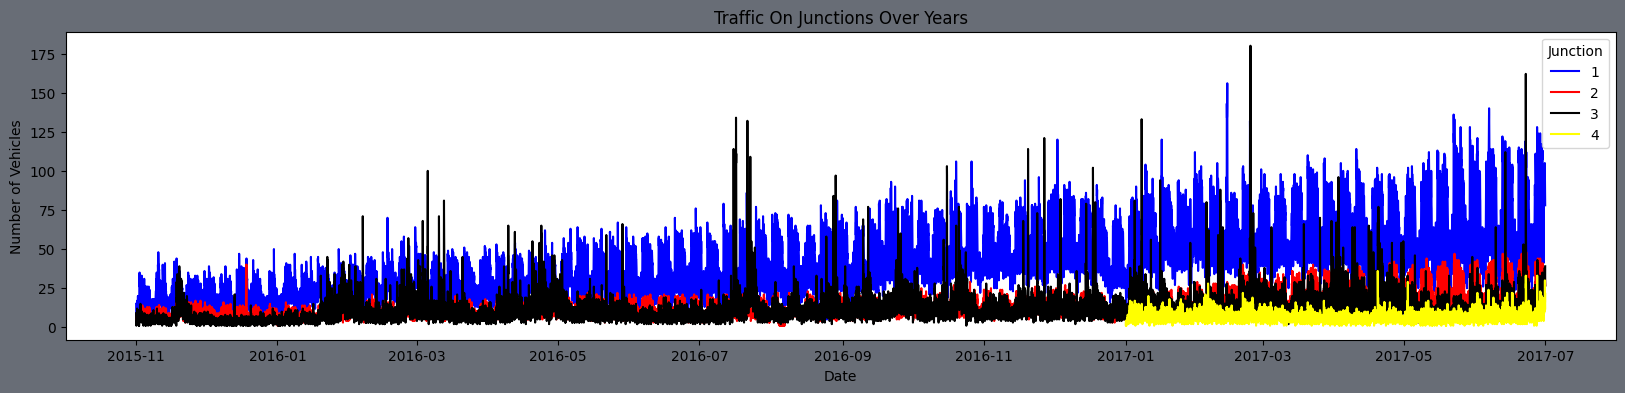

In [6]:
df=data.copy()
#Let's plot the Timeseries
colors = ["blue", "red", "black", "yellow"]
plt.figure(figsize=(20,4),facecolor="#686D76")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")


In [7]:
#Pivoting data from junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.head()

Vehicles              
Junction                   1    2    3   4
DateTime                                  
2015-11-01 00:00:00     15.0  6.0  9.0 NaN
2015-11-01 01:00:00     13.0  6.0  7.0 NaN
2015-11-01 02:00:00     10.0  5.0  5.0 NaN
2015-11-01 03:00:00      7.0  6.0  1.0 NaN
2015-11-01 04:00:00      9.0  7.0  2.0 NaN

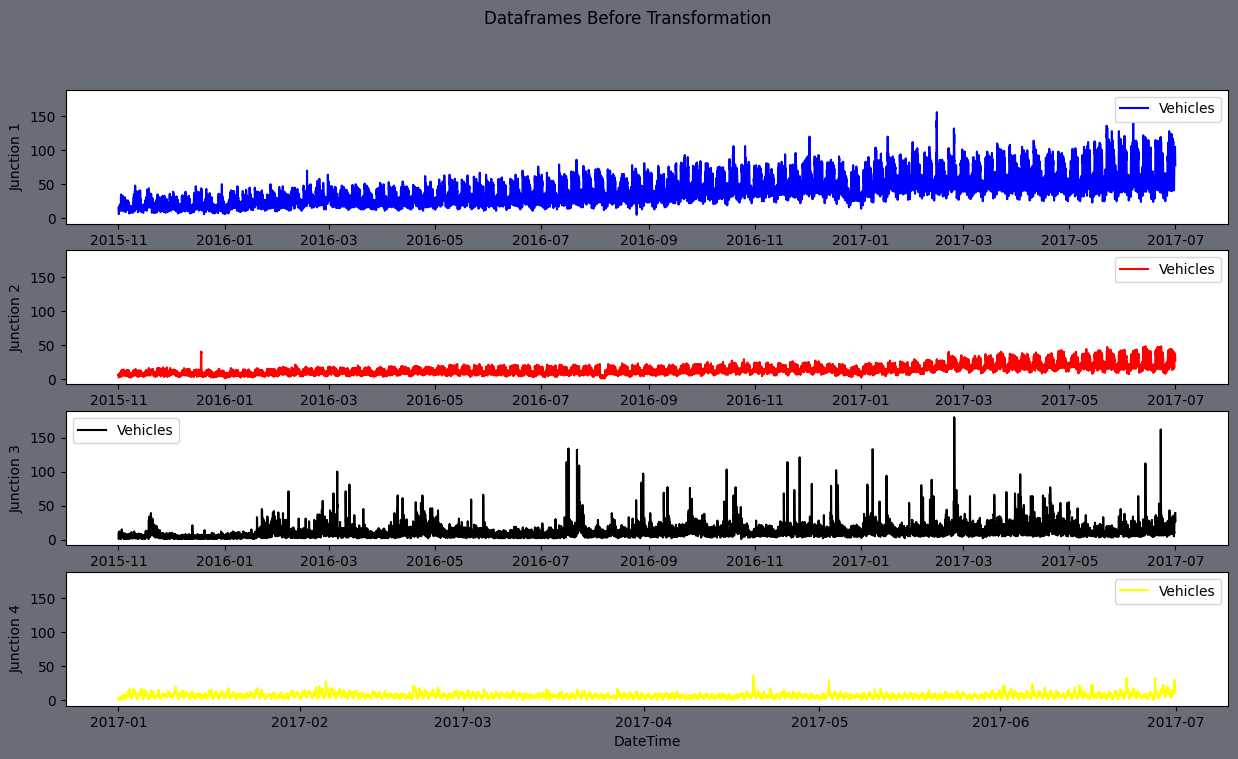

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creating new DataFrames for each junction
dfs = []
for junction_id in range(1, 5):
    df_junction = df_J[[('Vehicles', junction_id)]].dropna()
    df_junction.columns = df_junction.columns.droplevel(level=1)
    dfs.append(df_junction)

colors = ["blue", "red", "black", "yellow"]

fig, axes = plt.subplots(len(dfs), 1, figsize=(15, 8), facecolor="#686D76", sharey=True)
fig.suptitle("Dataframes Before Transformation")

for i, (df, color) in enumerate(zip(dfs, colors)):
    sns.lineplot(ax=axes[i], data=df, palette=[color])
    axes[i].set_ylabel(f"Junction {i+1}")

plt.show()


In [18]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

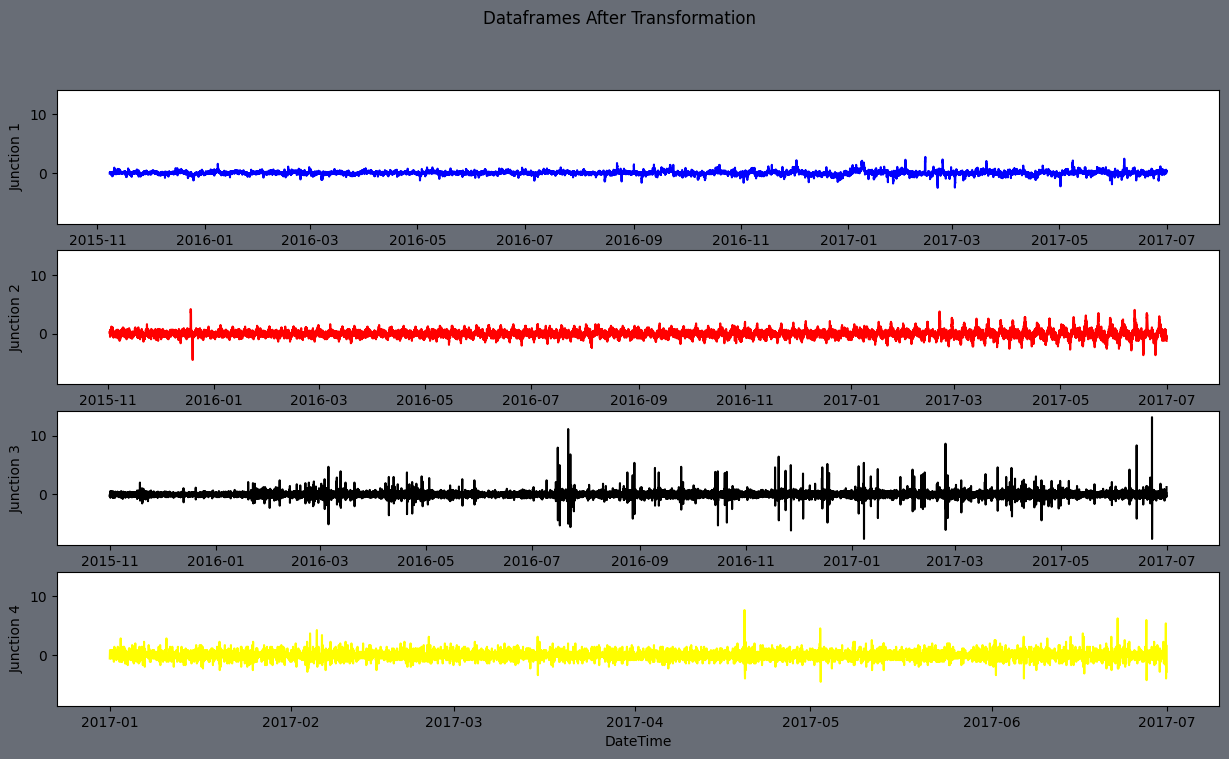

In [22]:
def normalize_and_difference(df, interval, col="Vehicles"):
    avg = df[col].mean()
    std = df[col].std()
    df_norm = (df[col] - avg) / std

    df_diff = df_norm.diff(periods=interval)

    df_norm = df_norm.iloc[interval:]
    df_norm.columns = ["Norm"]
    df_diff = df_diff.iloc[interval:]
    df_diff.columns = ["Diff"]

    # Combine normalized and differenced data into a single DataFrame
    return pd.DataFrame({"Norm": df_norm, "Diff": df_diff}), avg, std

# Applying normalization and differencing for each dataframe
df_N1, av_J1, std_J1 = normalize_and_difference(df_1, interval=24*7)
df_N2, av_J2, std_J2 = normalize_and_difference(df_2, interval=24)
df_N3, av_J3, std_J3 = normalize_and_difference(df_3, interval=1)
df_N4, av_J4, std_J4 = normalize_and_difference(df_4, interval=1)

# Call Sub_Plots4 with the 'Diff' column of each DataFrame
Sub_Plots4(df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"], "Dataframes After Transformation")

In [23]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [31]:
#Differencing created some NA values
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [30]:
X_trainJ1.shape

(12949, 32, 1)

In [32]:
# Custom the Layer
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [35]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

def Custom_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Flatten(input_shape=(X_Train.shape[1], X_Train.shape[2])))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_Custom = model.predict(X_Test)
    return pred_Custom

def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)
    X_Test = np.squeeze(X_Test)
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def PredictionsPlot(test, predicted, color):
    plt.figure(figsize=(12, 5), facecolor="#686D76")
    plt.plot(test, color=color, label="True Value", alpha=0.5)
    plt.plot(predicted, color="yellow", label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()




In [38]:
# Predictions For First Junction
print("Custom Model Predictions")
PredJ1_Custom = Custom_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("GRU Model Predictions")
PredJ1_GRU = GRU_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("LSTM Model Predictions")
PredJ1_LSTM = LSTM_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("CNN Model Predictions")
PredJ1_CNN = CNN_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("MLP Model Predictions")
PredJ1_MLP = MLP_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)


Custom Model Predictions
Epoch 1/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0726 - val_loss: 0.0692
Epoch 2/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0565 - val_loss: 0.0650
Epoch 3/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0629
Epoch 4/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0624
Epoch 5/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0608
Epoch 6/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0606
Epoch 7/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0600
Epoch 8/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0602
Epoch 9/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0473 - val_loss: 0.0600
Epoch 10/50
108/108 [==============================] - 0s 3ms/step - loss: 

Custom Model Results
The root mean squared error is 0.2420491742395589.


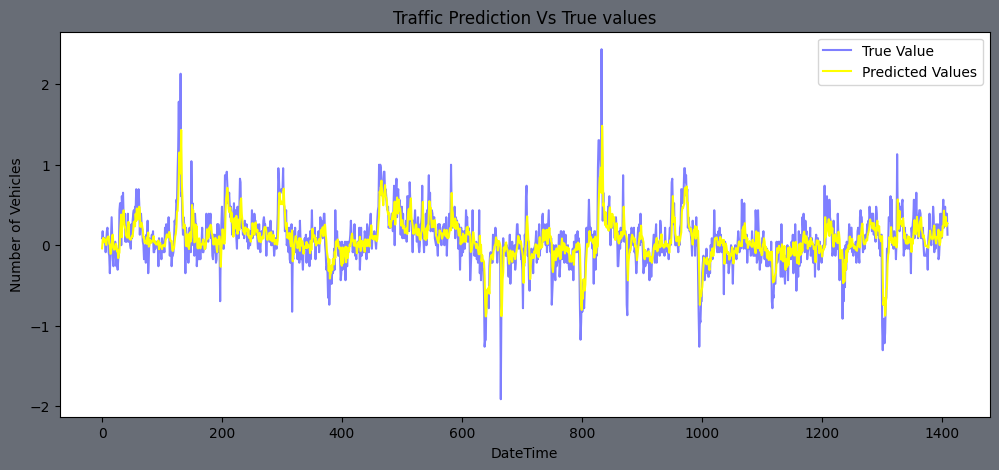

GRU Model Results
The root mean squared error is 0.24991231276301715.


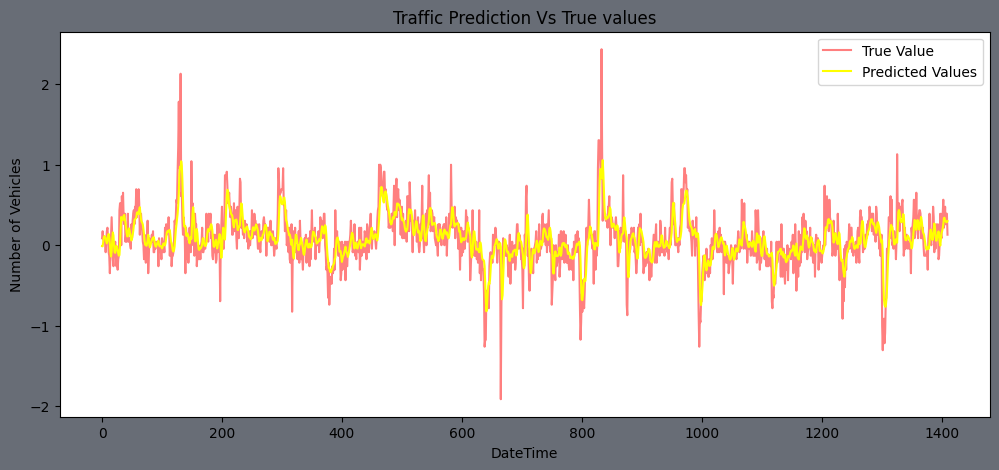

LSTM Model Results
The root mean squared error is 0.2726503070587528.


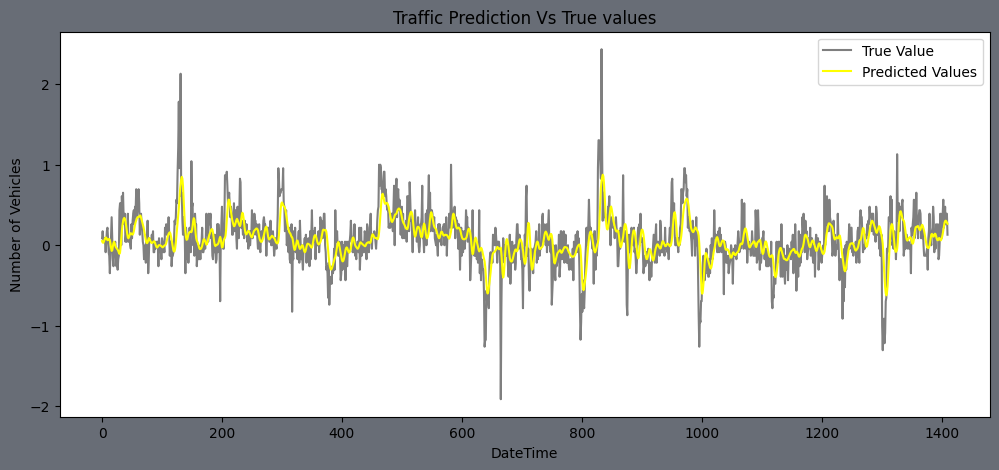

CNN Model Results
The root mean squared error is 0.247652727420208.


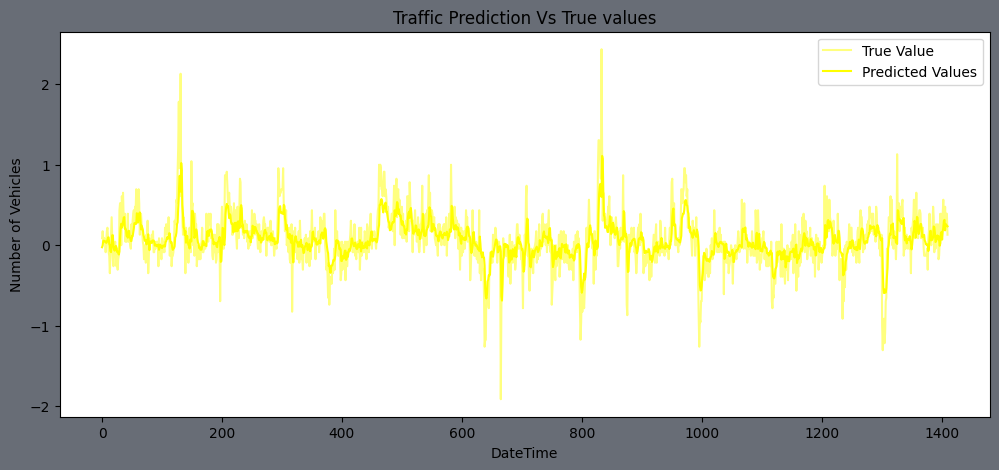

MLP Model Results
The root mean squared error is 0.24328859403503894.


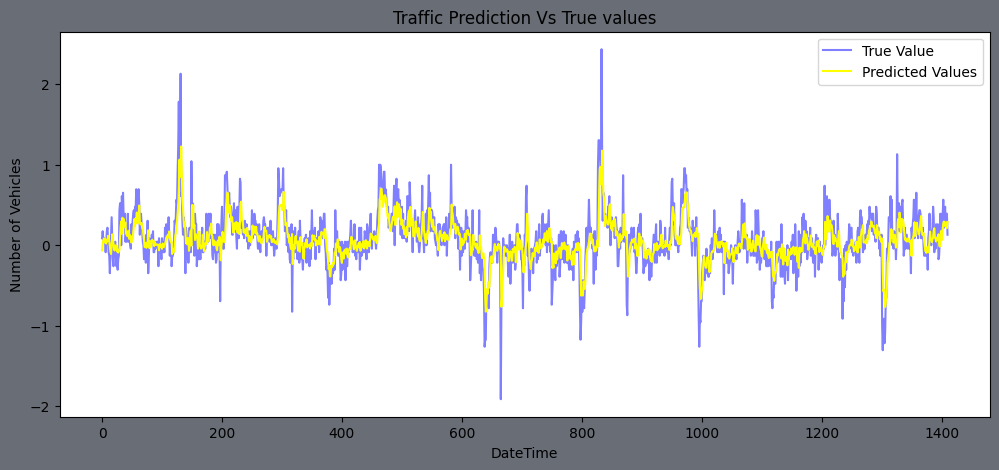


Best Model: Custom - RMSE: 0.2420491742395589


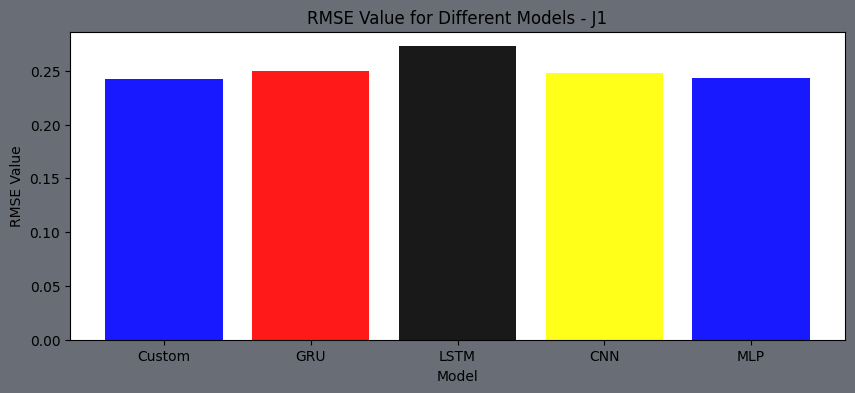

,MODEL,RMSE
0,Custom,0.242049
1,GRU,0.249912
2,LSTM,0.272650
3,CNN,0.247653
4,MLP,0.243289


In [39]:
# Results for J1 - Custom Model
print("Custom Model Results")
RMSE_J1_Custom = RMSE_Value(y_testJ1, PredJ1_Custom)
PredictionsPlot(y_testJ1, PredJ1_Custom, 'blue')

# Results for J1 - GRU Model
print("GRU Model Results")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 'red')

# Results for J1 - LSTM Model
print("LSTM Model Results")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 'black')

# Results for J1 - CNN Model
print("CNN Model Results")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 'yellow')

# Results for J1 - MLP Model
print("MLP Model Results")
RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
PredictionsPlot(y_testJ1, PredJ1_MLP, 'blue')

# Create DataFrame for model names and their RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J1_Custom, RMSE_J1_GRU, RMSE_J1_LSTM, RMSE_J1_CNN, RMSE_J1_MLP]
model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])

# Find the best model and its RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name = model_names[best_model_index]
best_model_rmse = rmse_values[best_model_index]

# Print the best model and its RMSE value
print("\nBest Model: {} - RMSE: {}".format(best_model_name, best_model_rmse))

# Plot bar graph for model names and RMSE values
colors = ['blue', 'red', 'black', 'yellow', 'blue']
plt.figure(figsize=(10, 4), facecolor="#686D76")
plt.bar(model_names, rmse_values, color=colors, alpha=0.9)
plt.xlabel('Model')
plt.ylabel('RMSE Value')
plt.title('RMSE Value for Different Models - J1')
plt.show()

# Display DataFrame with styled formatting
styled_df = Results_df.style.background_gradient(cmap="cool")
display(styled_df)


Reducing the number of epochs in the following process improves efficiency by decreasing the time required for model training while still providing reasonable predictive performance.

In [60]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

def Custom_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Flatten(input_shape=(X_Train.shape[1], X_Train.shape[2])))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=10, batch_size=120, callbacks=[early_stopping])
    pred_Custom = model.predict(X_Test)
    return pred_Custom

def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=10, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=10, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=10, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)
    X_Test = np.squeeze(X_Test)
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=10, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def PredictionsPlot(test, predicted, color):
    plt.figure(figsize=(12, 5), facecolor="#686D76")
    plt.plot(test, color=color, label="True Value", alpha=0.5)
    plt.plot(predicted, color="yellow", label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()




In [64]:
# Predictions For second Junction
print("Custom Model Predictions")
PredJ2_Custom = Custom_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

print("GRU Model Predictions")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

print("LSTM Model Predictions")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

print("CNN Model Predictions")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

print("MLP Model Predictions")
PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)


Custom Model Predictions
Epoch 1/10
109/109 [==============================] - 1s 4ms/step - loss: 0.2086 - val_loss: 0.2792
Epoch 2/10
109/109 [==============================] - 0s 3ms/step - loss: 0.1621 - val_loss: 0.2532
Epoch 3/10
109/109 [==============================] - 0s 3ms/step - loss: 0.1572 - val_loss: 0.2405
Epoch 4/10
109/109 [==============================] - 0s 3ms/step - loss: 0.1506 - val_loss: 0.2367
Epoch 5/10
109/109 [==============================] - 0s 4ms/step - loss: 0.1483 - val_loss: 0.2352
Epoch 6/10
109/109 [==============================] - 1s 5ms/step - loss: 0.1472 - val_loss: 0.2384
Epoch 7/10
109/109 [==============================] - 1s 5ms/step - loss: 0.1447 - val_loss: 0.2306
Epoch 8/10
109/109 [==============================] - 0s 5ms/step - loss: 0.1446 - val_loss: 0.2394
Epoch 9/10
109/109 [==============================] - 0s 5ms/step - loss: 0.1422 - val_loss: 0.2319
Epoch 10/10
45/45 [==============================] - 0s 2ms/step
----------

Custom Model Results
The root mean squared error is 0.49157433446662924.


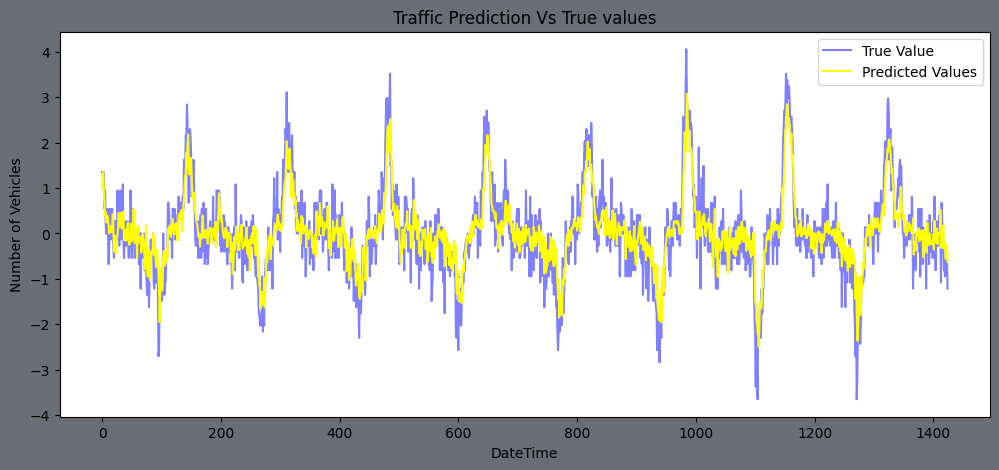

GRU Model Results
The root mean squared error is 0.5649543724143716.


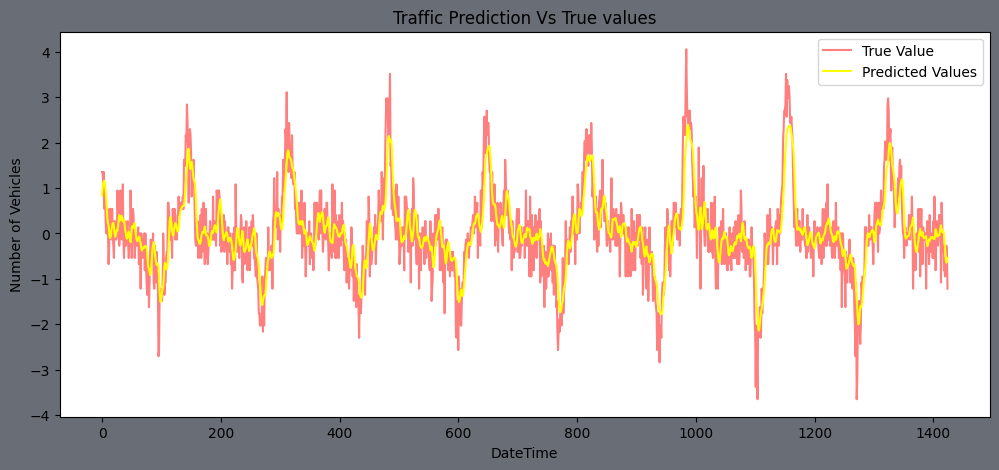

LSTM Model Results
The root mean squared error is 0.6902309519832811.


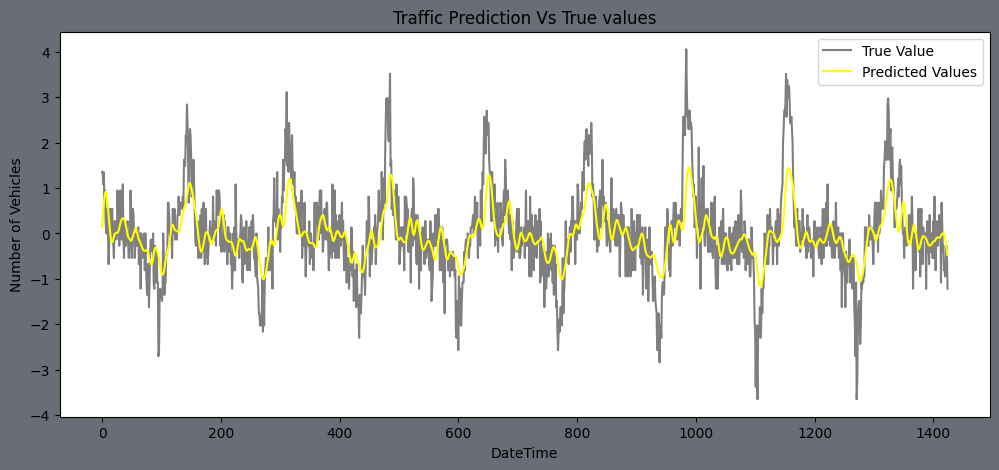

CNN Model Results
The root mean squared error is 0.567809907098598.


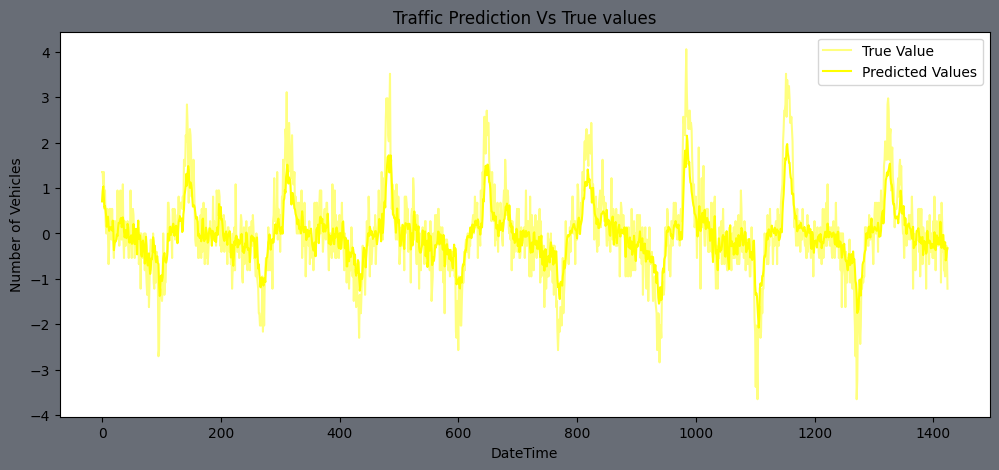

MLP Model Results
The root mean squared error is 0.5004600731833387.


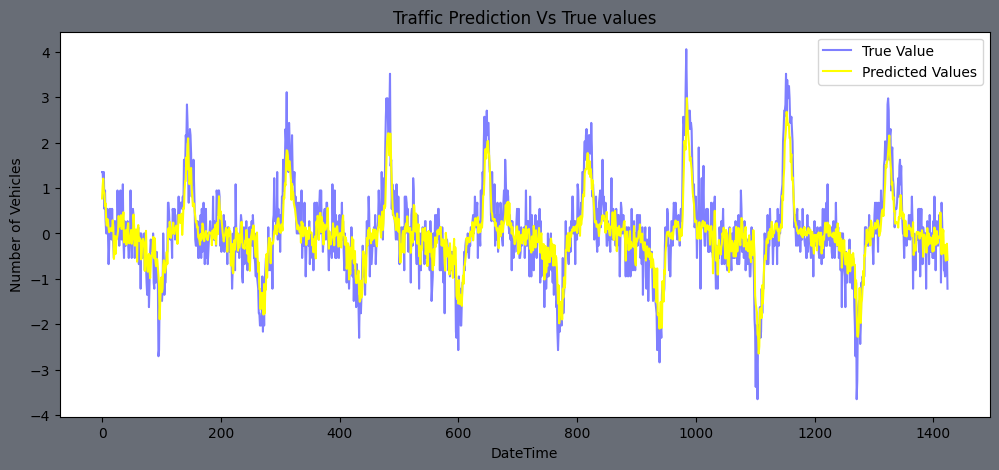


Best Model: Custom - RMSE: 0.49157433446662924


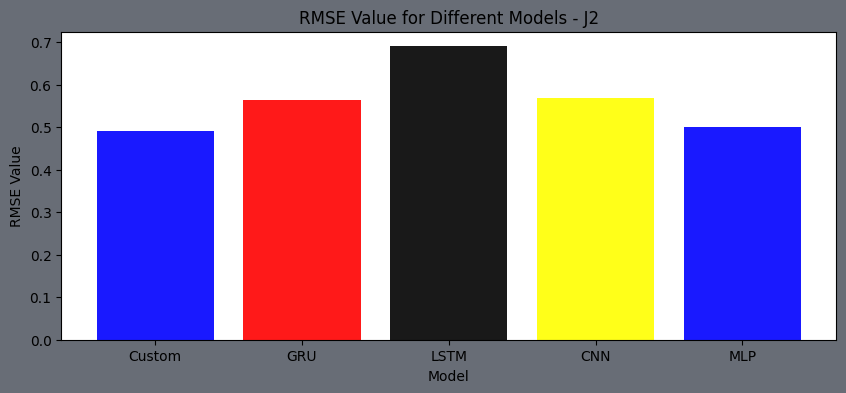

,MODEL,RMSE
0,Custom,0.491574
1,GRU,0.564954
2,LSTM,0.690231
3,CNN,0.567810
4,MLP,0.500460


In [66]:
# Results for J2 - Custom Model
print("Custom Model Results")
RMSE_J2_Custom = RMSE_Value(y_testJ2, PredJ2_Custom)
PredictionsPlot(y_testJ2, PredJ2_Custom, 'blue')

# Results for J2 - GRU Model
print("GRU Model Results")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 'red')

# Results for J2 - LSTM Model
print("LSTM Model Results")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 'black')

# Results for J2 - CNN Model
print("CNN Model Results")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 'yellow')

# Results for J2 - MLP Model
print("MLP Model Results")
RMSE_J2_MLP = RMSE_Value(y_testJ2, PredJ2_MLP)
PredictionsPlot(y_testJ2, PredJ2_MLP, 'blue')

# Create DataFrame for model names and their RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J2_Custom, RMSE_J2_GRU, RMSE_J2_LSTM, RMSE_J2_CNN, RMSE_J2_MLP]
model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])

# Find the best model and its RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name = model_names[best_model_index]
best_model_rmse = rmse_values[best_model_index]

# Print the best model and its RMSE value
print("\nBest Model: {} - RMSE: {}".format(best_model_name, best_model_rmse))

# Plot bar graph for model names and RMSE values
colors = ['blue', 'red', 'black', 'yellow', 'blue']
plt.figure(figsize=(10, 4), facecolor="#686D76")
plt.bar(model_names, rmse_values, color=colors, alpha=0.9)
plt.xlabel('Model')
plt.ylabel('RMSE Value')
plt.title('RMSE Value for Different Models - J2')
plt.show()

# Display DataFrame with styled formatting
styled_df = Results_df.style.background_gradient(cmap="cool")
display(styled_df)


In [69]:
# Initialise data of lists for error values of two junctions.
Junctions = ["Junction2"]
RMSE = [best_model_rmse]
Model = [best_model_name]
list_of_tuples = list(zip(Junctions, RMSE, Model))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")

,Junction,RMSE,MODEL
0,Junction2,0.491574,Custom


In [82]:
import pandas as pd

best_model_rmse_1 = 0.240003
best_model_rmse_2 = 0.472742
best_model_name_1 = "Custom"
best_model_name_2 = "Custom"

# Initialise data of lists for error values of two junctions.
Junctions = ["Junction1", "Junction2"]
RMSE = [best_model_rmse_1, best_model_rmse_2]
Model = [best_model_name_1, best_model_name_2]
list_of_tuples = list(zip(Junctions, RMSE, Model))

# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")


,Junction,RMSE,MODEL
0,Junction1,0.240003,Custom
1,Junction2,0.472742,Custom
